# Loads in the dataframes

In [5]:
import pandas as pd
import numpy as np
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
%matplotlib inline

# loads the dataframes
higgs_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttH.hd5')
semi_leptonic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttsemileptonic.hd5')

# labels signal vs background
semi_leptonic_df["signal"] = 0
higgs_df["signal"] = 1

# combines the dataframes and randomly shuffles the rows
full_df = semi_leptonic_df.append(higgs_df, ignore_index=True)
full_df = shuffle(full_df)

event_cols = [
    "BiasedDPhi",
    "DiJet_mass",
    "HT",
    "InputMet_InputJet_mindPhi",
    "InputMet_pt",
    "MHT_pt",
    "MinChi",
    "MinOmegaHat",
    "MinOmegaTilde",
    "ncleanedBJet",
    "ncleanedJet",
]

object_cols = [
    "cleanedJet_pt",
    "cleanedJet_area",
    "cleanedJet_btagDeepB",
    "cleanedJet_chHEF",
    "cleanedJet_eta",
    "cleanedJet_mass",
    "cleanedJet_neHEF",
    "cleanedJet_phi",
]

df = full_df[event_cols + object_cols + ["signal"]]

# Splits data into event / object dataframes and train / test dataframes

In [6]:
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence

scaler = StandardScaler()

# columns that should not be transformed
untransformed_cols = ["ncleanedBJet", "ncleanedJet", "BiasedDPhi", "signal"]
transformed_cols = list(set(event_cols) - set(untransformed_cols))

# takes the log of each column to remove skewness
for col_name in event_cols:
    if col_name in transformed_cols:
        df[col_name] = np.log(df[col_name])

# splits data into training and validation
X, y = df.drop("signal", axis=1), df["signal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# divides training data into object level and event level features
event_X_train, event_X_test = X_train[event_cols], X_test[event_cols]
object_X_train, object_X_test = X_train[object_cols], X_test[object_cols]

# scales features so they all have the same mean and variance
event_X_train[event_cols] = scaler.fit_transform(event_X_train[event_cols].values)
event_X_test[event_cols] = scaler.transform(event_X_test[event_cols].values)

max_jets = df["ncleanedJet"].max()

# pads input sequences with zeroes so they're all the same length
for col in object_cols:
    object_X_train[col] = sequence.pad_sequences(
        object_X_train[col].values, padding="post", dtype="float32"
    ).tolist()
    object_X_test[col] = sequence.pad_sequences(
        object_X_test[col].values, padding="post", dtype="float32"
    ).tolist()

print(
    "Removed Columns:",
    [col for col in full_df.columns if col not in set(event_cols + object_cols)],
)
X_train.head()

Removed Columns: ['dataset', 'entry', 'InputMet_phi', 'MHT_phi', 'hashed_filename', 'weight_nominal', 'xs_weight', 'signal']


,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,cleanedJet_pt,cleanedJet_area,cleanedJet_btagDeepB,cleanedJet_chHEF,cleanedJet_eta,cleanedJet_mass,cleanedJet_neHEF,cleanedJet_phi
356633,0.465117,6.352167,6.430526,-0.348063,5.682729,5.520374,-0.104213,-0.365112,-0.486807,0,4,"[300.05148, 199.0432, 71.03875, 50.366753]","[0.4987793, 0.5288086, 0.39892578, 0.4987793]","[0.19506836, 0.040863037, 0.18847656, 0.31713867]","[0.875, 0.5390625, 0.796875, 0.44921875]","[0.8701172, -0.54785156, -0.39282227, -0.6621094]","[31.15625, 33.71875, 10.890625, 11.625]","[0.026123047, 0.034179688, 0.052246094, 0.0703...","[-2.7695312, 1.3359375, 1.8164062, -0.08441162]"
140591,-2.687177,5.798620,6.177997,0.357456,5.355406,5.424517,0.040700,-0.031291,-0.785298,0,6,"[155.76634, 131.57791, 65.845116, 57.081795, 3...","[0.48876953, 0.4987793, 0.5185547, 0.48876953,...","[0.19104004, 0.36865234, 0.13586426, 0.1882324...","[0.5546875, 0.28515625, 0.2578125, 0.28515625,...","[-0.24707031, 1.3916016, -1.328125, -0.7412109...","[26.921875, 17.6875, 12.5078125, 6.5039062, 5....","[0.140625, 0.4453125, 0.076171875, 0.017578125...","[-1.7705078, 2.9589844, -0.13208008, -1.172851..."
87460,-1.917960,5.212948,5.710680,0.860051,5.648974,5.511424,0.451583,-0.003525,-0.321411,0,2,"[160.15276, 141.92366]","[0.5185547, 0.48876953]","[0.050842285, 0.31518555]","[0.30078125, 0.35546875]","[0.37890625, 0.78125]","[20.59375, 33.71875]","[0.11230469, 0.026611328]","[-1.7841797, -3.0078125]"
39780,-2.865919,5.816710,5.866214,0.187354,5.423848,5.462653,0.350248,-0.025922,-0.794144,3,5,"[160.01846, 96.894455, 34.84461, 30.871433, 30...","[0.48876953, 0.4987793, 0.55859375, 0.4987793,...","[0.7109375, 0.9248047, 0.04788208, 0.6142578, ...","[0.6171875, 0.5546875, 0.7109375, 0.4453125, 0...","[1.7099609, -0.42822266, -0.33398438, 1.097656...","[32.53125, 11.8359375, 7.6914062, 6.2421875, 5...","[0.037109375, 0.09375, 0.11621094, 0.35546875,...","[-2.9121094, -2.0664062, 1.640625, 1.4013672, ..."
260886,-2.948233,4.646579,5.386322,1.086824,5.378168,5.381699,0.451583,0.059913,-0.393383,1,2,"[121.3293, 97.0693]","[0.5288086, 0.5385742]","[0.11114502, 0.12854004]","[0.5625, 0.2578125]","[-1.3603516, -2.2695312]","[16.75, 19.21875]","[0.2109375, 0.33984375]","[-2.8027344, -2.9960938]"


# Loads preprocessed data

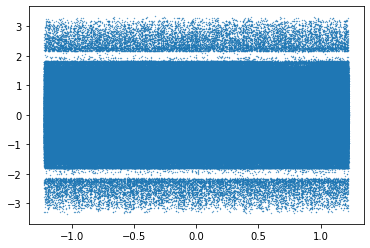

In [7]:
import matplotlib.pyplot as plt

object_X_train = np.load('/content/drive/MyDrive/RNN_classifier/object_X_train.npy')
object_X_test = np.load('/content/drive/MyDrive/RNN_classifier/object_X_test.npy')

plt.scatter(object_X_train[:, :, 7], object_X_train[:, :, 4], s=0.1)

# Hyperparameters

In [8]:
# binary classifier neural network
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from sklearn.utils import class_weight

# hyperparameters
activation = "relu"
batch_size = 64
epochs = 8
loss = "binary_crossentropy"

# l2 regularization doesn't seem to help
lstm_l2 = 0
mlp_l2 = 0

initializer = tf.keras.initializers.VarianceScaling()

# metrics
def f1_score(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="AUC"),
    f1_score,
]

monitor = 'val_loss'
mode = 'auto'

# stops training early if score doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    verbose=1,
    patience=3,
    mode=mode,
    restore_best_weights=True,
)

# saves the network at regular intervals so you can pick the best version
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/RNN_classifier/best_model_v2.h5",
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode=mode,
    save_freq="epoch",
)

class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = {l: c for l, c in zip(np.unique(y_train), class_weights)}

# Hyperparameter Optimization using Bayesian Optimization

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
from tensorflow import keras
import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Concatenate, BatchNormalization, LayerNormalization, Dropout
from keras.regularizers import l2
from keras import Model

def model1(hp):
    DNN_model = Sequential()
    DNN_model.add(Dense(hp.Int('units1', min_value=40, max_value=400, step=20),
                  input_shape=(event_X_train.shape[1],),
                  activation=activation, 
                  kernel_regularizer=l2(mlp_l2),
                  kernel_initializer=initializer,)
    )
    
    DNN_model.add(BatchNormalization())
    
    if hp.Boolean("dropout"):
        DNN_model.add(Dropout(hp.Float('dropout_val', min_value=0.0, max_value=0.5, step=0.05)))

    RNN_model = Sequential(
        [
            LSTM(
                hp.Int('units2', min_value=40, max_value=400, step=20),
                input_shape=(object_X_train.shape[1], object_X_train.shape[2]),
                activation="tanh",
                recurrent_dropout=hp.Float('redroput', min_value=0.05, max_value=0.5, step=0.05),
                kernel_regularizer=l2(lstm_l2),
                kernel_initializer=initializer,
            ),
            LayerNormalization(axis=-1 , center=True , scale=True),
        ]
    )

    merged = Concatenate()([DNN_model.output, RNN_model.output])

    z = Dense(hp.Int('units3', min_value=40, max_value=400, step=20),
              activation=activation,
              kernel_regularizer=l2(mlp_l2),
              kernel_initializer=initializer)(merged)
              
    z = BatchNormalization()(z)

    if hp.Boolean("dropout"):
        z = Dropout(hp.Float('dropout_val', min_value=0.0, max_value=0.5, step=0.05))(z)

    if hp.Boolean("layer4"):
        z = Dense(hp.Int('units4', min_value=40, max_value=400, step=20),
                  activation=activation,
                  kernel_regularizer=l2(mlp_l2),
                  kernel_initializer=initializer)(z)

        z = BatchNormalization()(z)

        if hp.Boolean("dropout"):
            z = Dropout(hp.Float('dropout_val', min_value=0.0, max_value=0.5, step=0.05))(z)

        if hp.Boolean("layer5"):
            z = Dense(hp.Int('units5', min_value=40, max_value=400, step=20),
                      activation=activation,
                      kernel_regularizer=l2(mlp_l2),
                      kernel_initializer=initializer)(z)

            z = BatchNormalization()(z)

            if hp.Boolean("dropout"):
                z = Dropout(hp.Float('dropout_val', min_value=0.0, max_value=0.5, step=0.05))(z)
                        
    z = Dense(1, activation="sigmoid")(z) 

    model = Model(inputs=[DNN_model.input, RNN_model.input], outputs=z)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-4, 1e-3, 1e-2])), 
        loss="binary_crossentropy", 
        metrics=METRICS)

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    model1,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='/tmp/tb',
    overwrite=True,)

bayesian_opt_tuner.search(
             [event_X_train, object_X_train], y_train, 
             epochs=epochs,
             validation_data=([event_X_test, object_X_test], y_test),
             class_weight=class_weights,
             callbacks=[early_stopping, checkpoint, keras.callbacks.TensorBoard("/tmp/tb_logs")],
             )


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units1            |220               |?                 
dropout           |True              |?                 
units2            |40                |?                 
redroput          |0.5               |?                 
units3            |320               |?                 
layer4            |True              |?                 
lr                |0.001             |?                 

Epoch 1/8
9270/9271 [============================>.] - ETA: 0s - loss: 0.4647 - accuracy: 0.7685 - precision: 0.5258 - recall: 0.7839 - AUC: 0.8521 - f1_score: 0.6320
Epoch 00001: val_loss improved from inf to 0.42136, saving model to /content/drive/MyDrive/RNN_classifier/best_model_v2.h5
9271/9271 [==============================] - 206s 22ms/step - loss: 0.4647 - accuracy: 0.7685 - precision: 0.5258 - recall: 0.7839 - AUC: 0.8521 - f1_score: 0.6320 - val_loss: 0.4214 - val_accuracy: 0.8053 - val_precision: 0.5